In [1]:
"""

Date: 18 March 2020

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

Only single convolutional layer, no flex
Max pooling following

"""

# imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

#create a dataset subset to reduce training time

sampler_train = list(range(0, len(trainset), 1000))
sampler_test = list(range(0, len(testset), 1000))
trainset_samp = torch.utils.data.Subset(trainset, sampler_train)
testset_samp = torch.utils.data.Subset(testset, sampler_test)

#set size of batch and learning rate
batch_size=4
lr=0.001

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

100.0%

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


83.3%

0.4%0%

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


100.0%

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


159.1%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*12*12, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (1) hidden conv layer
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 12 * 12 * 12)))
        
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [4]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

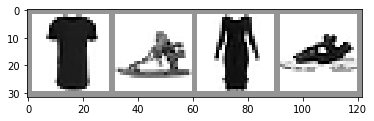

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
#writer.add_image('four_fake_images', img_grid)

In [6]:
#from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(comment=f'2_Bigdataset_test1-Optimisation-Xavier  batch_size={batch_size} lr={lr}')

C:\Users\User\Anaconda3\envs\meng\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

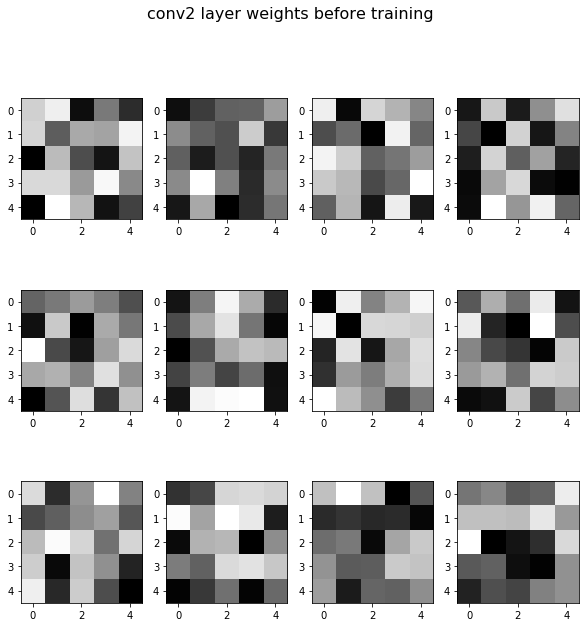

In [7]:
# plot the flex weights before training

fig = plt.figure()
plt.figure(figsize=(10,10))
plt.suptitle('conv2 layer weights before training', fontsize = 16)
for idx, filt  in enumerate(net.conv2.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(3,4, idx + 1)
    plt.imshow(net.conv2.weight.detach().numpy()[idx,0,:,:], cmap="gray")

    
fig.show()

In [8]:
running_loss = 0.0
total_loss_plt = []
for epoch in range(50):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0
    
    nsamples = 1000

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)
    
    # ...log the total epoch accuracy
    # writer.add_scalar('Accuracy', total_correct / len(trainset), epoch)
       
    total_loss_plt.append(total_loss)
        
    print("epoch:", epoch, "loss:", total_loss)
        
print('Finished Training')

epoch: 0 loss: 29892.043300582678
epoch: 1 loss: 19113.402836345456
epoch: 2 loss: 16467.14536854597
epoch: 3 loss: 14694.981265491486
epoch: 4 loss: 13364.252741418557
epoch: 5 loss: 12232.868604117215
epoch: 6 loss: 11103.501251859623
epoch: 7 loss: 10211.82076512601
epoch: 8 loss: 9441.080588106099
epoch: 9 loss: 8575.645971896245
epoch: 10 loss: 8034.88552185604
epoch: 11 loss: 7368.571322002929
epoch: 12 loss: 6682.295664811943
epoch: 13 loss: 6193.721493485709
epoch: 14 loss: 5935.259568757061
epoch: 15 loss: 5348.438464915171
epoch: 16 loss: 5138.008983522978
epoch: 17 loss: 4745.83002028335
epoch: 18 loss: 4353.882236471816
epoch: 19 loss: 3802.6788309784506
epoch: 20 loss: 3609.158221065734
epoch: 21 loss: 3862.368219772524
epoch: 22 loss: 3444.596009047594
epoch: 23 loss: 3301.9740023329755
epoch: 24 loss: 2901.6853984624126
epoch: 25 loss: 2639.435690670782
epoch: 26 loss: 2617.991349400757
epoch: 27 loss: 2619.589808029895
epoch: 28 loss: 2599.08484060294
epoch: 29 loss: 23

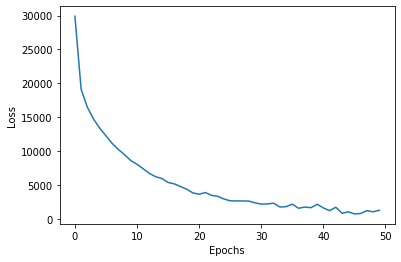

In [9]:
plt.plot(total_loss_plt)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [10]:
print('Accuracy is ', total_correct / len(trainset))

Accuracy is  0.9934833333333334


C:\Users\User\Anaconda3\envs\meng\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

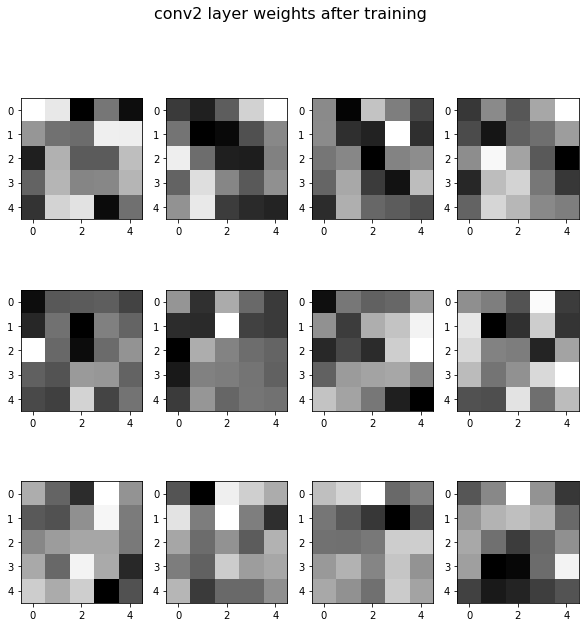

In [11]:
# plot the conv2 weights after training

fig = plt.figure()
fig = plt.figure(figsize=(10,10))
plt.suptitle('conv2 layer weights after training', fontsize = 16)
for idx, filt  in enumerate(net.conv2.weight.detach().numpy()[:,0,:,:]):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(net.conv2.weight.detach().numpy()[idx,0,:,:], cmap="gray")
#plt.colorbar()

    
fig.show()

In [25]:
path = "./models/xxx.pt"
torch.save(net.state_dict(), path)

<Figure size 432x288 with 0 Axes>

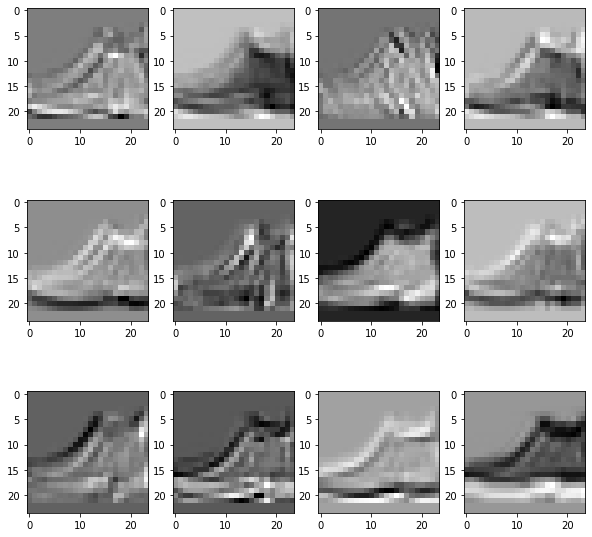

In [42]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv2.register_forward_hook(get_activation('conv2'))
data, _ = testset[0]
data.unsqueeze_(0)
output = net(data)


act = activation['conv2'].squeeze()
#fig, axarr = plt.subplots(act.size(0))
fig = plt.figure()
fig = plt.figure(figsize=(10,10))
for idx in range(act.size(0)):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(act[idx,:,:], cmap="gray")
    #axarr[idx].imshow(act[idx], cmap="gray")